In [61]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
RANDOM_SEED = 0

In [2]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    img = cv2.resize(img, img_size)  # Resize image
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm, 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

TRAIN_DIR = 'Dataset/TRAIN/'
TEST_DIR = 'Dataset/TEST/'
VAL_DIR = 'Dataset/VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


2216 images loaded from Dataset/TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


416 images loaded from Dataset/TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

368 images loaded from Dataset/VAL/ directory.


In [20]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

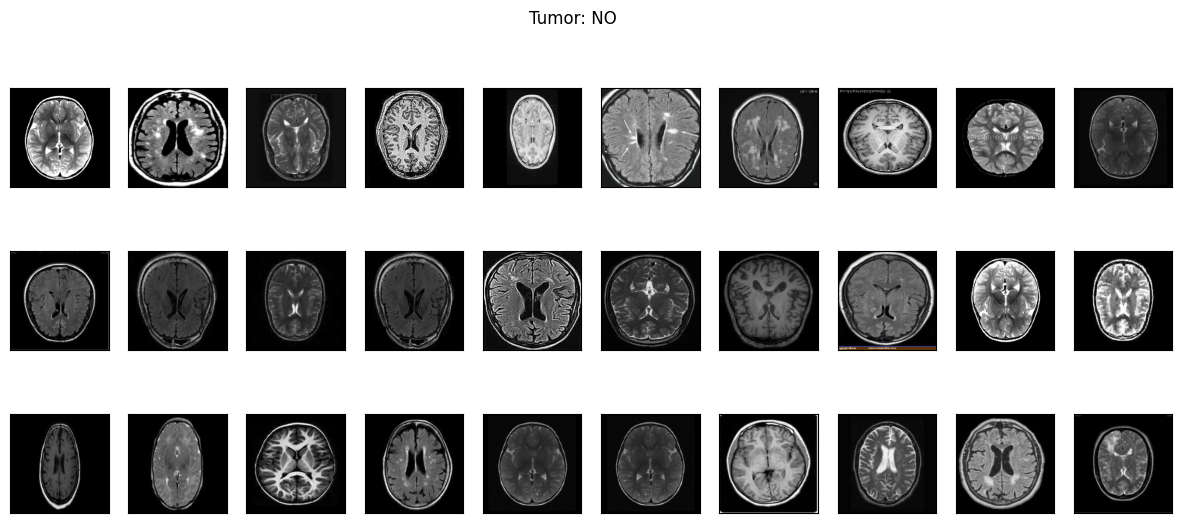

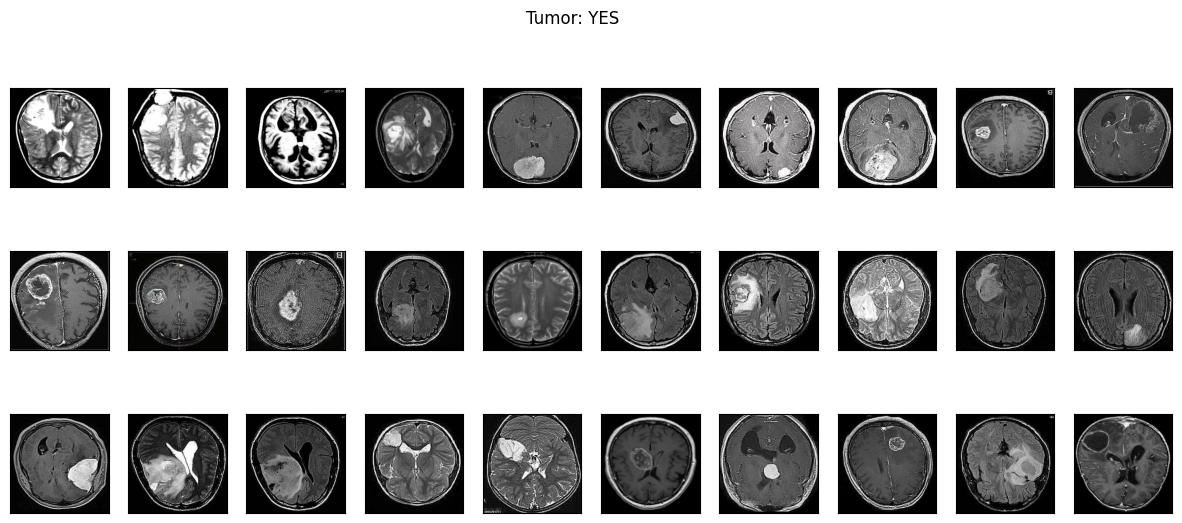

In [21]:
plot_samples(X_train, y_train, labels, 30)

In [22]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        if len(cnts) == 0:
            print("Warning: Contour not found in an image.")
            # If contour not found, append the original image
            set_new.append(img)
            continue
        
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        
        # Resize the image to a fixed size to ensure consistent shape
        new_img = cv2.resize(new_img, (IMG_SIZE[1], IMG_SIZE[0]))
        set_new.append(new_img)

    return np.array(set_new)

In [23]:
img = cv2.imread('Dataset/TRAIN/YES/y100.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

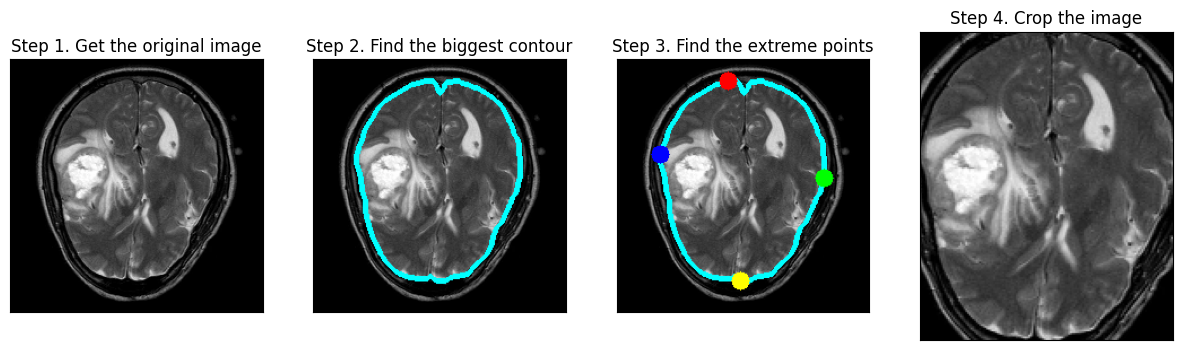

In [24]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [26]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

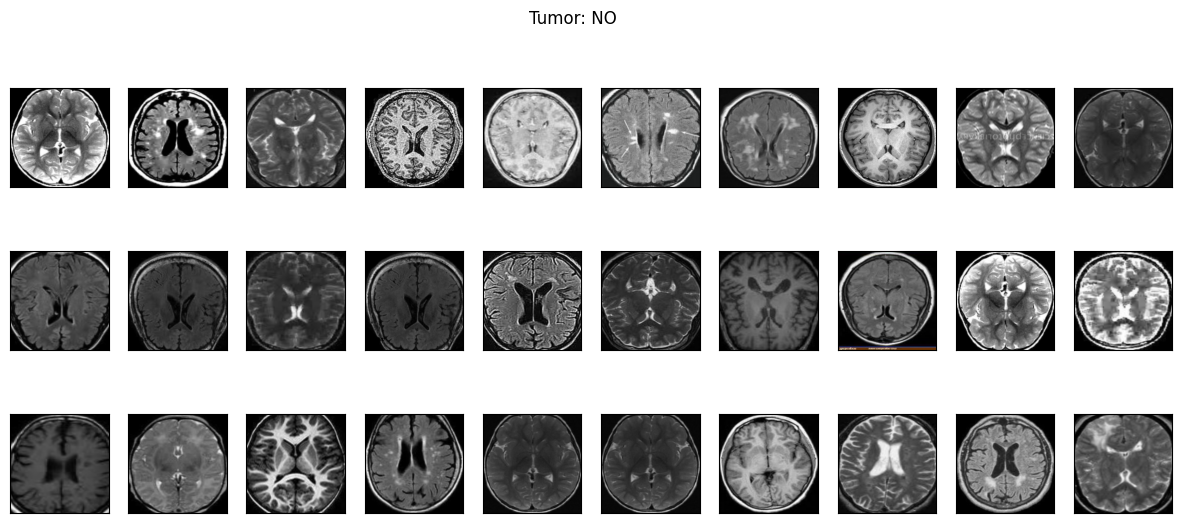

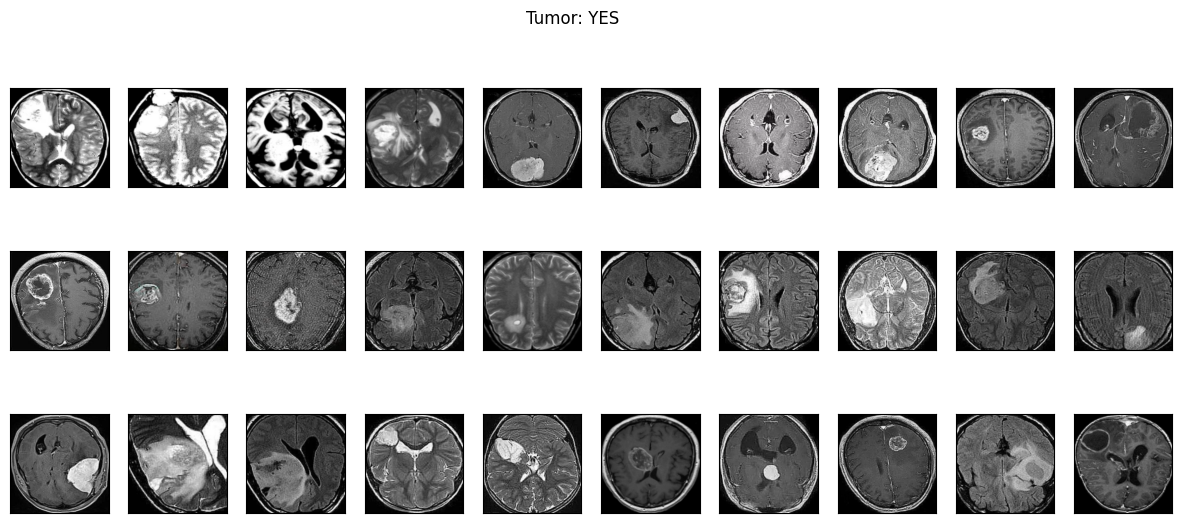

In [27]:
plot_samples(X_train_crop, y_train, labels, 30)

In [37]:
def save_new_images(x_set, y_set, folder_name):
    # Create directories if they don't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    if not os.path.exists(os.path.join(folder_name, 'NO')):
        os.makedirs(os.path.join(folder_name, 'NO'))
    if not os.path.exists(os.path.join(folder_name, 'YES')):
        os.makedirs(os.path.join(folder_name, 'YES'))
        
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(os.path.join(folder_name, 'NO', str(i) + '.jpg'), img)
        else:
            cv2.imwrite(os.path.join(folder_name, 'YES', str(i) + '.jpg'), img)
        i += 1
    print("Images saved successfully.")

In [38]:
save_new_images(X_train_crop, y_train, folder_name='Dataset/TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='Dataset/VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='Dataset/TEST_CROP/')

Images saved successfully.
Images saved successfully.
Images saved successfully.


In [39]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [40]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

# CNN Model

In [42]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [43]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

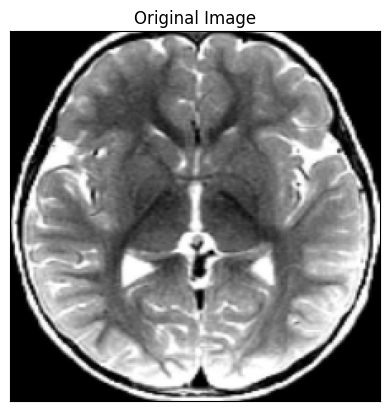

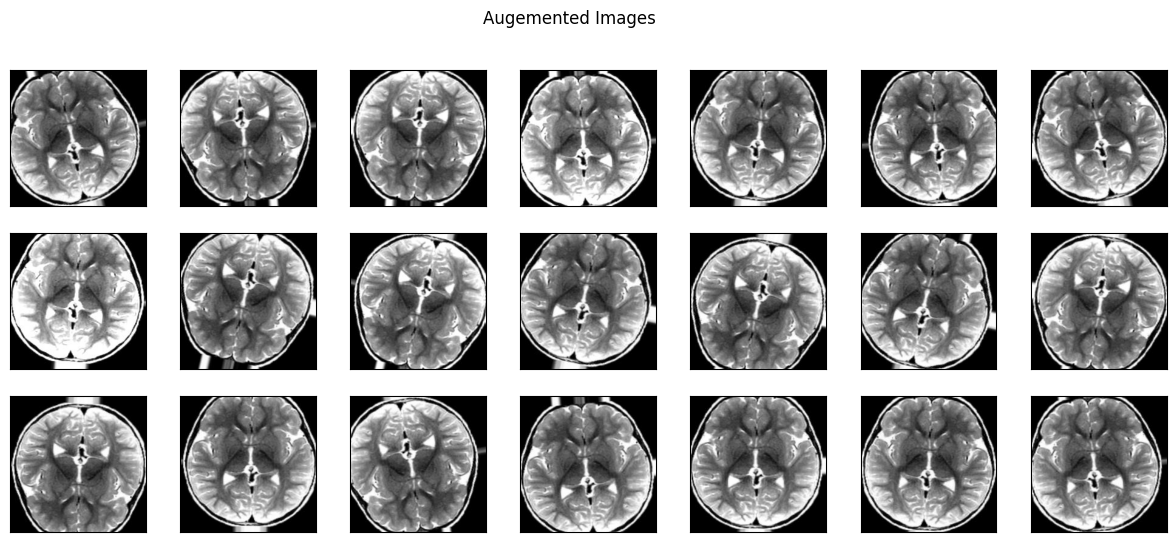

In [45]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [48]:
TRAIN_DIR = 'Dataset/TRAIN_CROP/'
VAL_DIR = 'Dataset/VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2216 images belonging to 2 classes.
Found 368 images belonging to 2 classes.


# MODEL BUILDING -> VGG16

In [49]:
base_model = VGG16(
    weights= 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [56]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

optimizer = Adam(learning_rate=0.001)  # Define optimizer

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.build(input_shape=(None, 224, 224, 3))  # Build the model with input shape

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [58]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=15,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7461 - loss: 3.3828 - val_accuracy: 0.9130 - val_loss: 0.9796
Epoch 2/30


c:\Python312\Lib\contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.

c:\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss



15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8271 - loss: 3.1252 - val_accuracy: 0.9103 - val_loss: 1.2029
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8172 - loss: 2.3002 - val_accuracy: 0.9049 - val_loss: 1.4972
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8671 - loss: 1.7603 - val_accuracy: 0.9321 - val_loss: 1.0438
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8888 - loss: 1.4328 - val_accuracy: 0.9348 - val_loss: 0.6650
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.8412 - loss: 2.2178 - val_accuracy: 0.9457 - val_loss: 0.7536
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8652 - loss: 1.9768 - val_accuracy: 0.9321 - val_loss: 1.0554
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8876 - loss: 1.4394 - val_accuracy: 0.9375 - val_loss: 0.9245
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8712 - loss: 1.6269 - val_accuracy: 0.8750 - val_loss: 2.0593
Epo

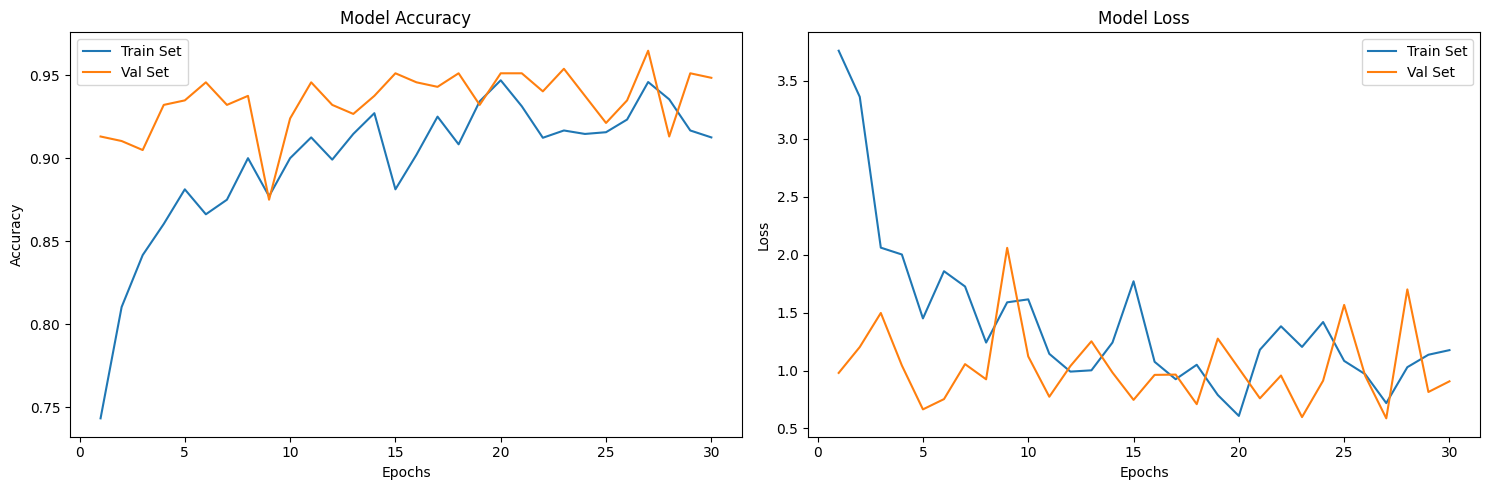

In [60]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# MODEL BUILDING -> Resnet50

In [62]:
base_model1 = ResNet50(
    weights= 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 335s 4us/step


In [63]:
NUM_CLASSES = 1

model1 = Sequential()
model1.add(base_model1)
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model1.layers[0].trainable = False

optimizer = Adam(learning_rate=0.001)  # Define optimizer

model1.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model1.build(input_shape=(None, 224, 224, 3))  # Build the model with input shape

model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │       100,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,688,065 (90.36 MB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [64]:
history1 = model1.fit(
    train_generator,
    steps_per_epoch=15,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5880 - loss: 4.3829 - val_accuracy: 0.8071 - val_loss: 1.5589
Epoch 2/30


c:\Python312\Lib\contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.

c:\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss



15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8280 - loss: 1.3802 - val_accuracy: 0.8641 - val_loss: 0.9528
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8970 - loss: 0.8462 - val_accuracy: 0.8967 - val_loss: 0.7580
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9130 - loss: 0.4473 - val_accuracy: 0.9266 - val_loss: 0.5516
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8858 - loss: 0.6911 - val_accuracy: 0.9049 - val_loss: 0.8347
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9326 - loss: 0.3026 - val_accuracy: 0.9185 - val_loss: 0.7014
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9408 - loss: 0.3184 - val_accuracy: 0.9293 - val_loss: 0.4771
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9165 - loss: 0.5421 - val_accuracy: 0.8723 - val_loss: 1.2656
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9310 - loss: 0.4544 - val_accuracy: 0.9375 - val_loss: 0.6988
Epo

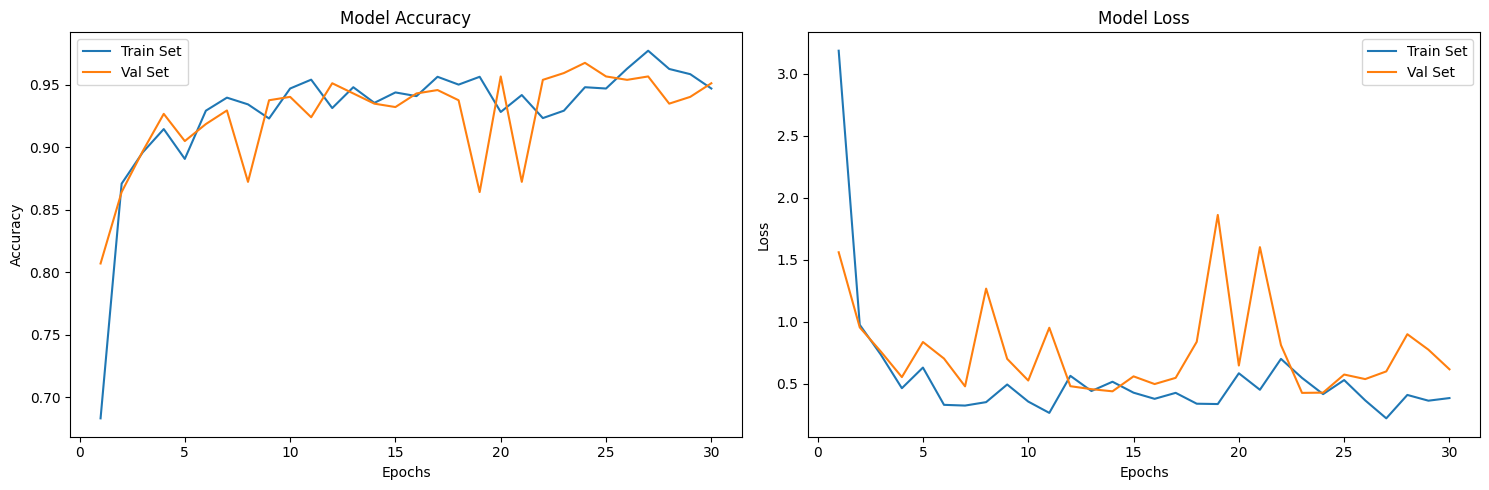

In [65]:
# plot model performance
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs_range = range(1, len(history1.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Train Set')
plt.plot(epochs_range, val_acc1, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Train Set')
plt.plot(epochs_range, val_loss1, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# MODEL BUILDING - InceptionV3

In [66]:
base_model2 = InceptionV3(
    weights= 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 278s 3us/step


In [69]:
NUM_CLASSES = 1

model2 = Sequential()
model2.add(base_model2)
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model2.layers[0].trainable = False

optimizer = Adam(learning_rate=0.001)  # Define optimizer

model2.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model2.build(input_shape=(None, 224, 224, 3))  # Build the model with input shape

model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │        51,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,853,985 (83.37 MB)

 Trainable params: 51,201 (200.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [68]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch=15,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4997 - loss: 42.2205 - val_accuracy: 0.5082 - val_loss: 33.0694
Epoch 2/30


c:\Python312\Lib\contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.

c:\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss



15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5833 - loss: 29.0715 - val_accuracy: 0.6576 - val_loss: 9.7944
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 921ms/step - accuracy: 0.5631 - loss: 17.1533 - val_accuracy: 0.6114 - val_loss: 13.5491
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 952ms/step - accuracy: 0.6485 - loss: 15.4095 - val_accuracy: 0.7255 - val_loss: 5.0316
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 685ms/step - accuracy: 0.6517 - loss: 14.1500 - val_accuracy: 0.5951 - val_loss: 15.3371
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 945ms/step - accuracy: 0.6633 - loss: 13.8780 - val_accuracy: 0.7038 - val_loss: 5.6092
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 945ms/step - accuracy: 0.6477 - loss: 11.9680 - val_accuracy: 0.7609 - val_loss: 5.2712
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 947ms/step - accuracy: 0.6656 - loss: 13.5706 - val_accuracy: 0.6766 - val_loss: 10.3241
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 919ms/step - accuracy: 0.6788 - loss: 14.2622 - val_accurac

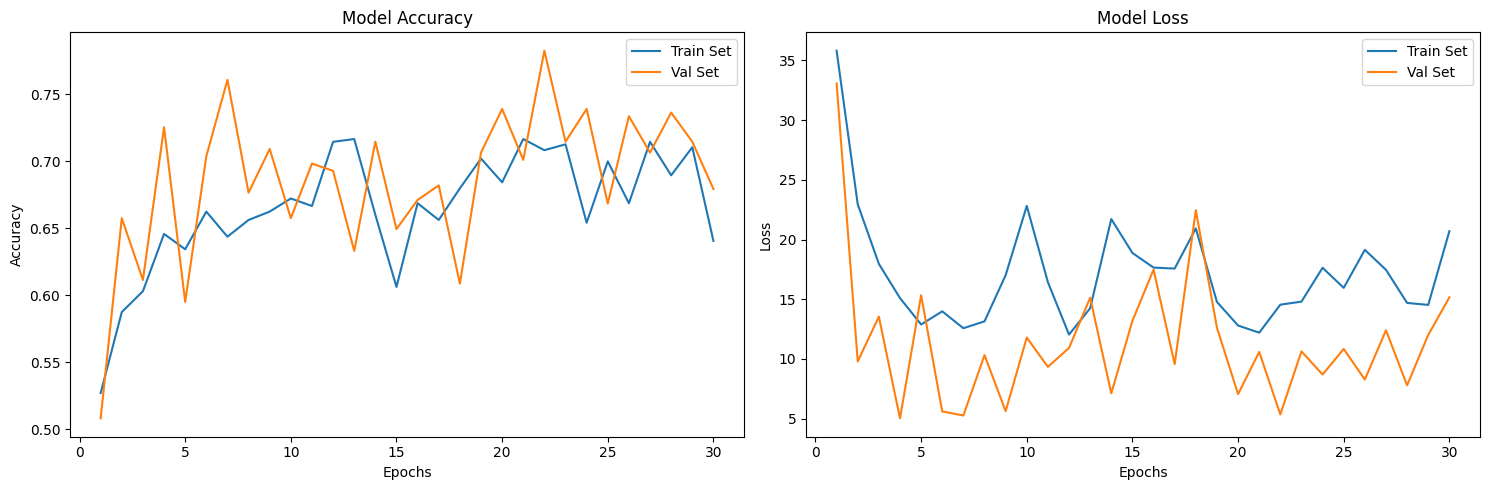

In [70]:
# plot model performance
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs_range = range(1, len(history2.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Train Set')
plt.plot(epochs_range, val_acc2, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Train Set')
plt.plot(epochs_range, val_loss2, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# MODEL BUILDING - DenseNet121

In [71]:
base_model3 = DenseNet121(
    weights= 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 111s 4us/step


In [72]:
NUM_CLASSES = 1

model3 = Sequential()
model3.add(base_model3)
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model3.layers[0].trainable = False

optimizer = Adam(learning_rate=0.001)  # Define optimizer

model3.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model3.build(input_shape=(None, 224, 224, 3))  # Build the model with input shape

model3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │        50,177 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,087,681 (27.04 MB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [73]:
history3 = model3.fit(
    train_generator,
    steps_per_epoch=15,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5908 - loss: 7.5737 - val_accuracy: 0.5625 - val_loss: 4.0476
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5749 - loss: 5.9957 - val_accuracy: 0.6033 - val_loss: 5.3597
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6324 - loss: 5.1530 - val_accuracy: 0.5190 - val_loss: 17.6126
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6457 - loss: 8.8054 - val_accuracy: 0.6196 - val_loss: 5.4385
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7490 - loss: 3.3400 - val_accuracy: 0.7065 - val_loss: 3.0130
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6989 - loss: 4.6516 - val_accuracy: 0.5842 - val_loss: 7.5746
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7042 - loss: 4.5039 - val_accuracy: 0.7120 - val_loss: 3.2958
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6891 - loss: 4.8518 - val_accuracy: 0.7120 - val_loss

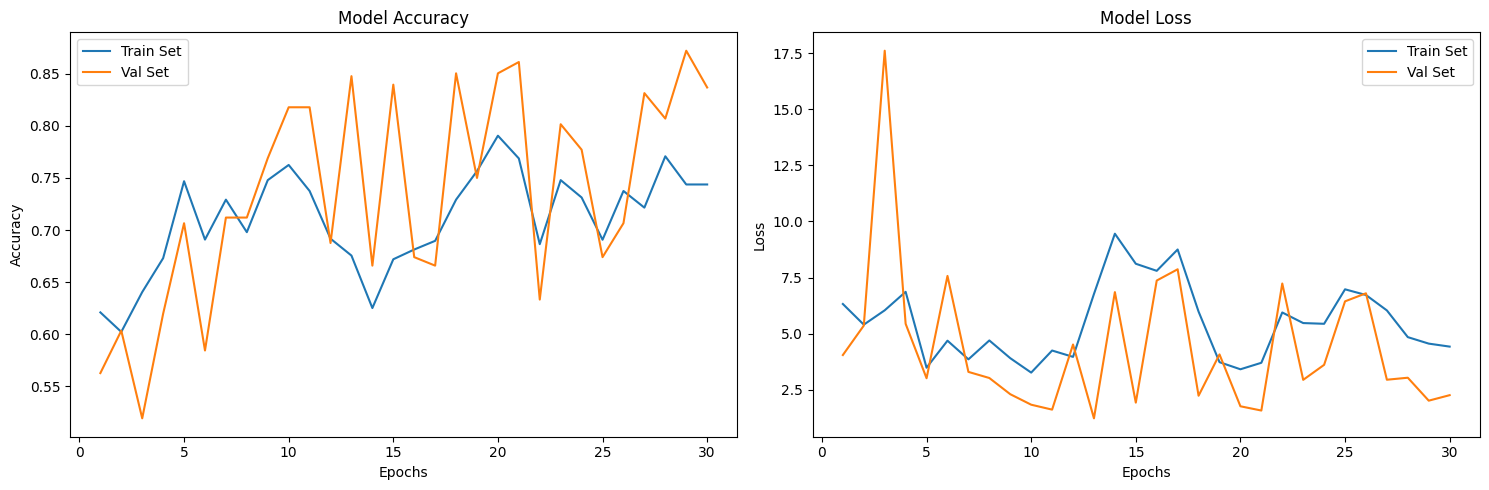

In [74]:
# plot model performance
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs_range = range(1, len(history3.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Train Set')
plt.plot(epochs_range, val_acc3, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Train Set')
plt.plot(epochs_range, val_loss3, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()